In [82]:
from transformers import pipeline
from germansentiment import SentimentModel
import pandas as pd
from tqdm import tqdm
import seaborn as sns

In [66]:
analyzer_fr = pipeline(
    task='text-classification',
    model="cmarkea/distilcamembert-base-sentiment",
    tokenizer="cmarkea/distilcamembert-base-sentiment"
)
model_de = SentimentModel()

In [67]:
def get_fr_sentiment(text):
    result = analyzer_fr(text, return_all_scores=True)
    res = 0
    for i in range(len(result[0])):
        if i < 2:
            res -= result[0][i]['score']
        elif i==2:
            continue
        elif i > 2:
            res += result[0][i]['score']
    return res

In [68]:
def get_de_sentiment(text):
    res = 0
    classes, probabilities = model_de.predict_sentiment([text], output_probabilities=True)
    for i in range(len(probabilities[0])):
        if i == 0:
            res -= probabilities[0][i][1]
        elif i==1:
            res += probabilities[0][i][1]
        elif i == 2:
            continue
    return res

In [69]:
get_de_sentiment("Totalrevision vom 12. September 1848")

5.4327449106494896e-05

In [70]:
get_fr_sentiment("Révision totale du 12 septembre 1848")

/Users/emilfunke/ETH/Master/semester_12/big-data-for-public-policy-2023/big_data_public_policy/.venv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


0.48008943349123

In [71]:
data = pd.read_excel('./data/DATASET XLSX 06-07-2023.xlsx', sheet_name='DATA')

In [76]:
text_data = data[['anr', 'datum', 'titel_kurz_d', 'titel_kurz_f', 'titel_off_d', 'titel_off_f']]

In [77]:
tqdm.pandas()
text_data['sentiment_d'] = text_data['titel_off_d'].progress_apply(get_de_sentiment)
text_data['sentiment_fr'] = text_data['titel_off_f'].progress_apply(get_fr_sentiment)

100%|██████████| 683/683 [00:27<00:00, 24.72it/s]
/var/folders/7j/4yddf5jd08n3l2v3ylwjbw_40000gn/T/ipykernel_37896/442075433.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_data['sentiment_d'] = text_data['titel_off_d'].progress_apply(get_de_sentiment)
  0%|          | 0/683 [00:00<?, ?it/s]/Users/emilfunke/ETH/Master/semester_12/big-data-for-public-policy-2023/big_data_public_policy/.venv/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:104: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
100%|██████████| 683/683 [00:13<00:00, 49.70it/s]
/var/folders/7j/4ydd

In [92]:
text_data.head()

,anr,datum,titel_kurz_d,titel_kurz_f,titel_off_d,titel_off_f,sentiment_d,sentiment_fr
0,1.0,12.09.1848,Bundesverfassung der schweizerischen Eidgenoss...,Constitution fédérale de la Confédération suisse,Totalrevision vom 12. September 1848,Révision totale du 12 septembre 1848,0.000054,0.480089
1,2.0,14.01.1866,Mass und Gewicht,Poids et mesures,Festsetzung von Mass und Gewicht,Poids et mesures,0.000044,0.431590
2,3.0,14.01.1866,Gleichstellung der Juden und Naturalisierten m...,Egalité des Juifs,Gleichstellung der Juden und Naturalisierten m...,Egalité des citoyens au point de vue de l'étab...,0.000003,0.741770
3,4.0,14.01.1866,Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",Stimmrecht der Niedergelassenen in Gemeindeang...,"Droit de vote des Suisses établis, en matière ...",0.000009,0.597496
4,5.0,14.01.1866,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,Besteuerung und zivilrechtliche Verhältnisse d...,Impôts et rapports civils des Suisses établis,0.000011,0.492853


<Axes: xlabel='anr', ylabel='sentiment_d'>

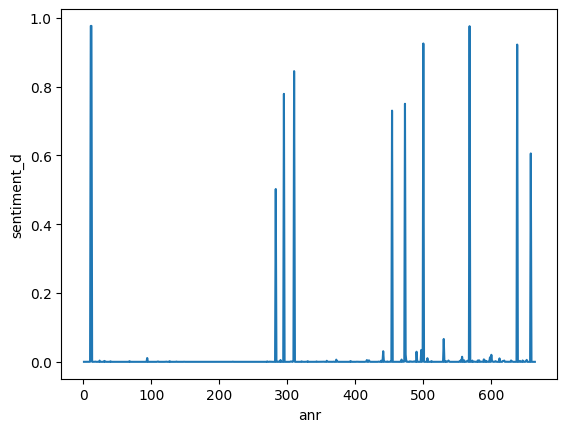

In [94]:
sns.lineplot(data=text_data, x='anr', y="sentiment_d")

<Axes: xlabel='anr', ylabel='sentiment_fr'>

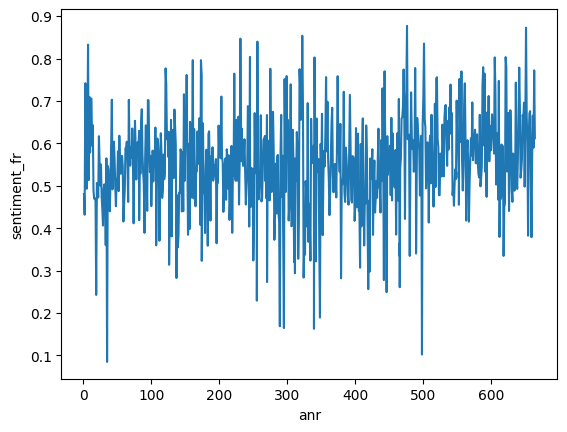

In [95]:
sns.lineplot(data=text_data, x='anr', y="sentiment_fr")

<Axes: xlabel='sentiment_fr', ylabel='Count'>

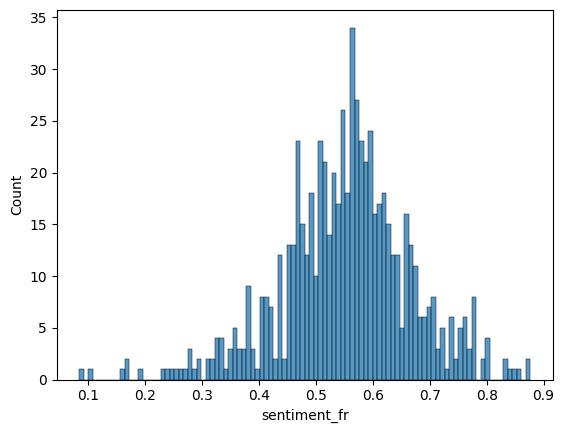

In [88]:
sns.histplot(data=text_data, x='sentiment_fr', bins=100)

In [1]:
import json
import pandas as pd
import numpy as np

import sparknlp
import pyspark.sql.functions as F

from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.types import StringType, IntegerType

In [2]:
spark = sparknlp.start()

23/07/13 21:42:12 WARN Utils: Your hostname, Emils-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.248 instead (on interface en0)
23/07/13 21:42:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
:: loading settings :: url = jar:file:/Users/emilfunke/ETH/Master/semester_12/big-data-for-public-policy-2023/big_data_public_policy/.venv/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /Users/emilfunke/.ivy2/cache
The jars for the packages stored in: /Users/emilfunke/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9c5576ea-6dfd-449a-82bc-0a5b1107a2f1;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;4.2.8 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.828 in central
	found com.github.universal-automata#liblevenshtein;3.0.0 in central
	found com.google.protobuf#protobuf-java-util;3.0.0-beta-3 in central
	found com.google.protobuf#protobuf-java;3.0.0-beta-3 in central
	found com.google.code.gson#gson;2.3 in central
	found it.unimi.dsi#fastutil;7.0.12 in central
	found org.projectlombok#lombok;1.16.8 in central
	found com.google.cloud#google-cloud-storage;2.15.0 in central
	found com.google.guava#guava;31.1-jre in central
	found com.google.guav

23/07/13 21:42:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
document_assembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

sequenceClassifier = BertForSequenceClassification \
      .pretrained('bert_sequence_classifier_multilingual_sentiment', 'xx') \
      .setInputCols(['token', 'document']) \
      .setOutputCol('class') \
      .setCaseSensitive(False) \
      .setMaxSentenceLength(512)

pipeline = Pipeline(stages=[
    document_assembler,
    tokenizer,
    sequenceClassifier
])

example = spark.createDataFrame([['I really liked that movie!']]).toDF("text")
result = pipeline.fit(example).transform(example)

bert_sequence_classifier_multilingual_sentiment download started this may take some time.
Approximate size to download 599 MB
[ | ]bert_sequence_classifier_multilingual_sentiment download started this may take some time.
Approximate size to download 599 MB
[ \ ]